In [ ]:
# def make_animation(source_image, driving_video, generator, kp_detector,
#                    relative=True, adapt_movement_scale=True):
#     with torch.no_grad():
#         predictions = []
#         source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

#         source = source.cuda()

#         driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
#         kp_source = kp_detector(source)
#         kp_driving_initial = kp_detector(driving[:, :, 0])

#         for frame_idx in tqdm(range(driving.shape[2])):
#             driving_frame = driving[:, :, frame_idx]
#             driving_frame = driving_frame.cuda()
#             kp_driving = kp_detector(driving_frame)
#             kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
#                                    kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
#                                    use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
#             out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

#             predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
#     return predictions

In [1]:
import cv2
from create_video import search_face
from skimage.transform import resize
from PIL import Image
import torch
import numpy as np
import imageio
from required import load_checkpoints, normalize_kp
from skimage import img_as_ubyte

In [2]:
def show_cv2(image):
    while True:
        cv2.imshow('Image', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [ ]:
# generator, kp_detector = load_checkpoints()

In [5]:
def search_face(frame, cascade, last_frame=None):
    faces = cascade.detectMultiScale(
        frame,
        scaleFactor=1.2,
        minNeighbors=6
    )

    if (len(faces) == 0) and (last_frame is None):
        return frame, last_frame
    elif len(faces) == 0:
        return last_frame, last_frame

    max_area_face = faces[0]

    for face in faces:
        if face[2] * face[3] > max_area_face[2] * max_area_face[3]:
            max_area_face = face

    face = max_area_face

    n = 0.3 * face[2]

    if face[2] > face[3]:

        high_a = int(face[1] - n) if face[1] > n else 0
        high_b = face[1] + face[2] + n
        high_b = int(high_b) if high_b < frame.shape[0] else frame.shape[0]

        n = int((face[2] - face[3] + n) / 2)

        weight_a = int(face[0]) - n if face[0] > n else 0
        weight_b = face[0] + face[3] + n
        weight_b = int(weight_b) if weight_b < frame.shape[1] else frame.shape[1]

        frame = frame[high_a:high_b, weight_a:weight_b]

    else:
        weight_a = int(face[0] - n) if face[0] > n else 0
        weight_b = face[0] + face[3] + n
        weight_b = int(weight_b) if weight_b < frame.shape[1] else frame.shape[1]

        n = int((face[3] - face[2] + n) / 2)

        high_a = int(face[1] - n) if face[1] > n else 0
        high_b = face[1] + face[2] + n
        high_b = int(high_b) if high_b < frame.shape[0] else frame.shape[0]

        frame = frame[high_a:high_b, weight_a:weight_b]

    return frame, frame

In [8]:
image_path = 'data/6.jpg'
video_path = 'data/4.mp4'
cascade = cv2.CascadeClassifier(r'data/haarcascade.xml')  

def show_image(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return Image.fromarray(frame)

In [7]:
# image = cv2.imread(image_path)
# image, _ = search_face(image, cascade)

In [9]:
image = cv2.imread(image_path)
faces = cascade.detectMultiScale(
    image,
    scaleFactor=1.2,
    minNeighbors=6
)

In [12]:
faces[0]

array([208, 257, 108, 108], dtype=int32)

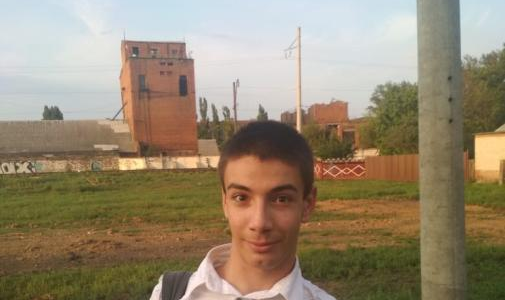

In [15]:
show_image(image[100:400])

In [ ]:
image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (256, 256))

In [ ]:
image

In [ ]:
face = faces[0]

In [ ]:
face

In [ ]:
high_a = int(face[1] - n) if face[1] > n else 0
high_b = face[1] + face[2] + n
high_b = int(high_b) if high_b < frame.shape[0] else frame.shape[0]

n = int((face[2] - face[3] + n) / 2)

weight_a = int(face[0]) - n if face[0] > n else 0
weight_b = face[0] + face[3] + n
weight_b = int(weight_b) if weight_b < frame.shape[1] else frame.shape[1]

frame = frame[high_a:high_b, weight_a:weight_b]

In [ ]:
image = cv2.imread(image_path)
image, _ = search_face(image, cascade)
image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (256, 256))
# show_image(image)

In [ ]:
image 

In [ ]:
image = image / 255

In [ ]:
video = cv2.VideoCapture(video_path)

In [ ]:
video.get(cv2.CAP_PROP_FPS)

In [ ]:
def make_animation(source_image, video, generator, kp_detector, video_path,
                   relative=True, adapt_movement_scale=True):
    with torch.no_grad():

        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        source = source.cuda()
        last_frame = None
        
        fps = video.get(cv2.CAP_PROP_FPS)
        codec = cv2.VideoWriter_fourcc(*'XVID')
        
        out = cv2.VideoWriter(video_path, codec, 20.0, (256, 256))
        
        kp_source = kp_detector(source)
        ret, frame = video.read()
        image, last_frame = search_face(frame, cascade, last_frame)
        image = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256))
        image = image / 255
        
        driving = torch.tensor(np.array(image)[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

        kp_driving_initial = kp_detector(driving)

        while True:

            frame, last_frame = search_face(frame, cascade, last_frame)
            frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256))
            frame = frame / 255
            driving = torch.tensor(np.array(frame)[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

            driving = driving.cuda()
            kp_driving = kp_detector(driving)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                    kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                    use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            predict = generator(source, kp_source=kp_source, kp_driving=kp_norm)\
                    
            predict = np.transpose(predict['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            cv2.cvtColor(predict, cv2.COLOR_BGR2RGB)
            out.write(predict)

            ret, frame = video.read()
            if not ret:
                break

    out.release()

In [ ]:
def make_animation(image, video, generator, kp_detector, cascade, video_path,
                   relative=True, adapt_movement_scale=True):
    with torch.no_grad():

        source = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        source = source.cuda()
        last_frame = None

        fps = video.get(cv2.CAP_PROP_FPS)
        codec = cv2.VideoWriter_fourcc(*'XVID')

        out = cv2.VideoWriter(video_path, codec, 20.0, (256, 256))

        kp_source = kp_detector(source)
        ret, frame = video.read()
        image, last_frame = search_face(frame, cascade, last_frame)
        image = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256))
        image = image / 255

        driving = torch.tensor(np.array(image)[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

        kp_driving_initial = kp_detector(driving)

        while True:

            frame, last_frame = search_face(frame, cascade, last_frame)
            frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256))
            frame = frame / 255
            driving = torch.tensor(np.array(frame)[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

            driving = driving.cuda()
            kp_driving = kp_detector(driving)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                   use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            predict = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predict = np.transpose(predict['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0]
            predict = cv2.cvtColor(predict, cv2.COLOR_BGR2RGB)
            predict = np.uint8(predict * 255)
            out.write(predict)

            ret, frame = video.read()
            if not ret:
                break

    out.release()

In [ ]:
predict = make_animation(image, video, generator, kp_detector, cascade, "data/test.mp4")

In [ ]:
predict = cv2.cvtColor(predict, cv2.COLOR_BGR2RGB)wav2lip

In [ ]:
predict = np.uint8(predict * 255)

In [ ]:
show_cv2(predict)

In [ ]:
cv2.imshow('хер', predict)

In [ ]:
np.uint8((predict * 255))

In [ ]:
show_image(np.uint8((predict * 255)))

In [ ]:
driving_video = imageio.mimread(video_path)
driving_video = [resize(frame, (256, 256)) for frame in driving_video]

In [ ]:
predictions = make_animation(image, driving_video, generator, kp_detector, relative=True)
imageio.mimsave('../generated2.mp4', [img_as_ubyte(frame) for frame in predictions])

In [ ]:
imageio.mimsave('../generated2.mp4', [img_as_ubyte(frame) for frame in predictions])

In [ ]:
driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
driving.shape

In [ ]:
driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)

In [ ]:
driving[:, :, 0].shape

In [ ]:
video = cv2.VideoCapture(video_path)
ret, frame = video.read()

In [ ]:
frame = search_face(frame, cascade)
frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256))
frame.shape

In [ ]:
torch.tensor(frame[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).shape